# Introduction

This notebook __attempts__ to explain how the depth loss function used in DS-NeRF works. The explanation is simplified to a single ray and a single depth measurement.

This notebook does not consider that the input depth may not have a uniform deviation in all directions and may need a covariance matrix or at least a view dependent deviation.

Last but not least, this notebook does not actually explain how the depth loss function works. It is more or less just a demonstration of its rather strange and inconsistent behavior that can't be even easily replicated in the original code in the first place.

Further viewer discretion is advised, my coding style has not improved since high school.

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

%matplotlib inline

## Preparing data

The following two parameters are a simplifiaction of what will be an observation used as an input for the DS-NeRF method.

In [3]:
D = 0.4
INPUT_ERR = 0.005

In [4]:
# ORIGINAL PYTORCH IMPLEMENTATION:
# loss = -torch.log(weights) * torch.exp(-(z_vals - depths[:,None]) ** 2 / (2 * err)) * dists
# loss = torch.sum(loss, dim=1)
eps = 1e-5

def loss(t, weights, D, err, delta):
    weights = weights + eps
    return -np.log(weights) * np.exp(-(t - D) ** 2 / (2 * err ** 2)) * delta

# def loss2(t, weights, D, err, delta):
#     weights = weights + eps
#     norm_part = (t - D) ** 2 / (2 * err)
#     loss = (1 / np.sqrt(err)) * np.exp(-norm_part) * (np.log(weights * np.sqrt(err)) + norm_part) * delta
#     return loss

In [5]:
t = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
weights = norm.pdf(t, loc=0.4, scale=0.001)
# weights = np.array([0.00001, 0.0001, 0.004, 0.9, 0.004, 0.0001, 0.00001])
print(loss(t, weights, D, 0.001, 0.1))
# print(loss2(t, weights, D, 0.001, 0.1))

[ 0.          0.          0.         -0.59888168  0.          0.
  0.        ]


In [6]:
def plot_loss(delta=0.01, lbound=0, rbound=1, weight_mean=D, weight_dev=INPUT_ERR, ylim=[-0.5, 1]):
    t = np.arange(start=lbound, stop=rbound, step=delta)
    weights = norm.pdf(t, loc=weight_mean, scale=weight_dev)
    loss_h = loss(t, weights, D, INPUT_ERR, delta)
    # loss_h2 = loss2(t, weights, D, INPUT_ERR, delta)

    plt.figure(figsize=(15,8))
    
    # Plotting original loss proposed in the paper
    plt.plot(t, loss_h * 100, label='Original loss')

    # Plotting loss that was directly derived from the Kullback-Leiber divergence
    # plt.plot(t, loss_h2, label='Derived loss')

    # Plotting measured depth distribution
    plt.plot(t, norm.pdf(t, loc=D, scale=INPUT_ERR), label='Ground truth depth distribution')

    # Plotting estimated depth distribution (equivalent to alpha compositing weights)
    plt.plot(t, weights, label='Predicted depth distribution')
    plt.legend()

    plt.ylim(ylim)
    print("Original loss:", np.sum(loss_h))
    # print("Derived loss:", np.sum(loss_h2))

In [6]:
def plot_loss_interactive(lbound=0, rbound=1, mean=D, var_rng=(0.001, 1, 0.001), ylim=[-0.5, 1], delta_rng=(0.0005, 0.1, 0.0005)):
    try:
        from ipywidgets import interact, interactive, fixed
        @interact(mean=(lbound, rbound, (rbound - lbound) / 100), delta=delta_rng, var=var_rng)
        def plot_loss_interactive(mean=mean, delta=0.01, var=0.005):
            t = np.arange(start=lbound, stop=rbound, step=delta)
            weights = norm.pdf(t, loc=mean, scale=var)
            loss_h = loss(t, weights, D, INPUT_ERR, delta)
            # loss_h2 = loss2(t, weights, D, INPUT_ERR, delta)

            plt.figure(figsize=(15,8))

            # Plotting original loss proposed in the paper
            plt.plot(t, loss_h, label='Original loss')

            # Plotting loss that was directly derived from the Kullback-Leiber divergence
            # plt.plot(t, loss_h2, label='Derived loss')

            # Plotting measured depth distribution
            plt.plot(t, norm.pdf(t, loc=D, scale=INPUT_ERR), label='Ground truth depth distribution')

            # Plotting estimated depth distribution (equivalent to alpha compositing weights)
            plt.plot(t, weights, label='Predicted depth distribution')
            plt.legend()
            
            plt.ylim(ylim)
            print("Original loss:", np.sum(loss_h))
            # print("Derived loss:", np.sum(loss_h2))

    except ImportError:
        print('Optional feature.')

In [7]:
def plot_loss_params():
    losses1 = [0] * 100
    losses2 = [0] * 100
    t_sigma = np.arange(INPUT_ERR - INPUT_ERR / 2 + 0.0001, INPUT_ERR + INPUT_ERR / 2, INPUT_ERR / 100)
    for i in range(100):
        t = np.arange(start=4.8, stop=5.2, step=0.01)
        weights1 = norm.pdf(t, loc=(D + (i * 0.4 / 100 - 0.2)), scale=INPUT_ERR)
        # losses1[i] = np.sum(loss2(t, weights1, D, INPUT_ERR, 0.01))
        weights2 = norm.pdf(t, loc=D, scale=t_sigma[i])
        # losses2[i] = np.sum(loss2(t, weights2, D, INPUT_ERR, 0.01))

    losses1 = np.array(losses1)
    losses2 = np.array(losses2)
    t_p = np.arange(start=4.8002, stop=5.2, step=0.004)
    
    plt.figure(figsize=(15,8))
    plt.plot(t_p, losses1)
    plt.plot(t_p, np.cbrt(losses1 + 1))

    plt.figure(figsize=(15,8))
    plt.plot(t_sigma, losses2)

    plt.figure(figsize=(15,8))
    plt.plot(t_sigma, np.cbrt(losses2 + 1))

## Experiments

Two lost functions were used in this notebook. The first one is the one that was proposed in the DS-NeRF paper. The second one was derived using the Kullback-Leibler divergence with minus removed.

This is what both losses look like when plotted for individual sample points in the case when both measured and estimated depth distribution are the same:

Original loss: -0.0502097776325623


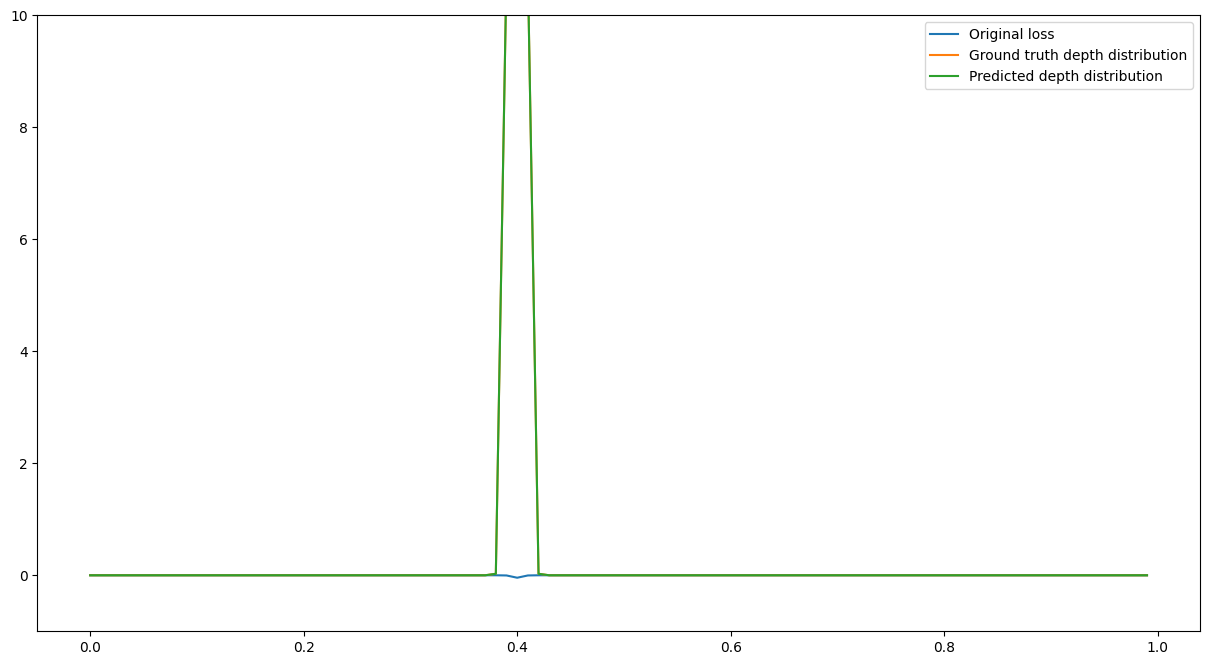

In [12]:
plot_loss(ylim=[-1,10], weight_mean=0.4, weight_dev=0.005)

As we can clearly see, both loss functions reach extreme values very quickly once we sample at a depth that is very unlikely. Since we want to minimize the loss, we can immediatelly see that both of these losses are useless since we reach either infinity or NaN in this very common case.

However, we can still attempt to plot compute the loss for the points that are likely to be near the ground truth depth in the first place. The following figure describes such a case:

Original loss: -0.04862081062938403


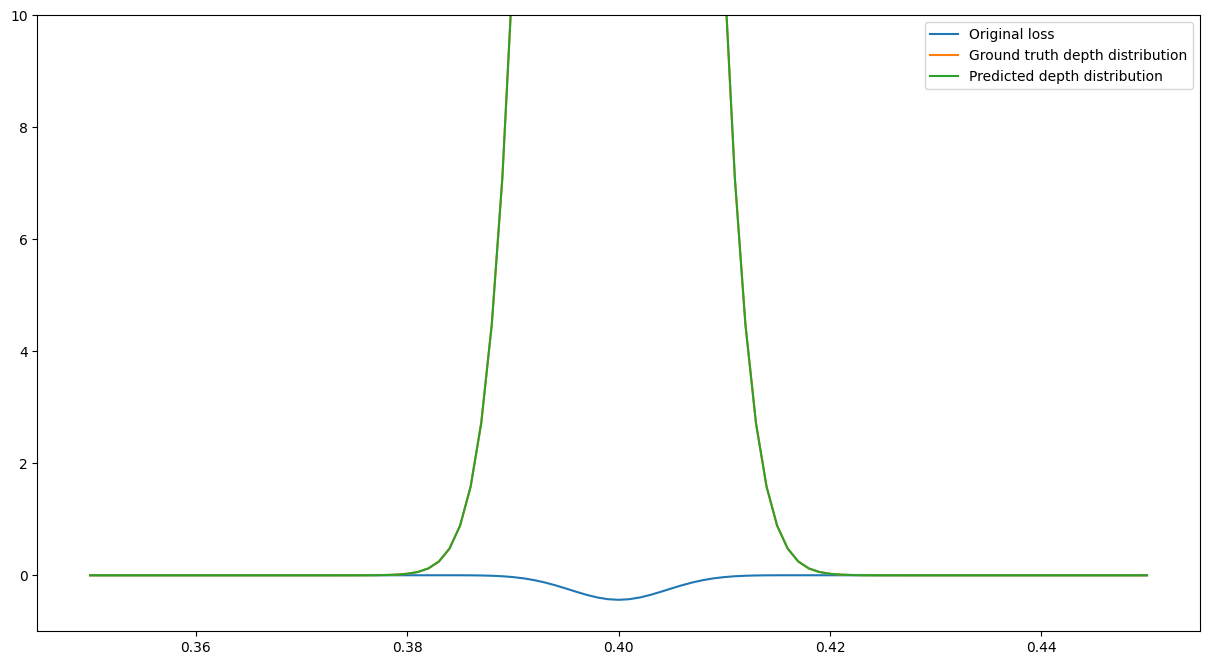

In [16]:
plot_loss(lbound=0.35, rbound=0.45, ylim=[-1, 10], delta=0.001)

While the derived loss behaves as it should, it penalizes all the query points that are far from the ground truth depth.

Now, we will look what happens when the estimated weight distribution has a mean that is different from the measured one.

Original loss: 0.1442928402971707


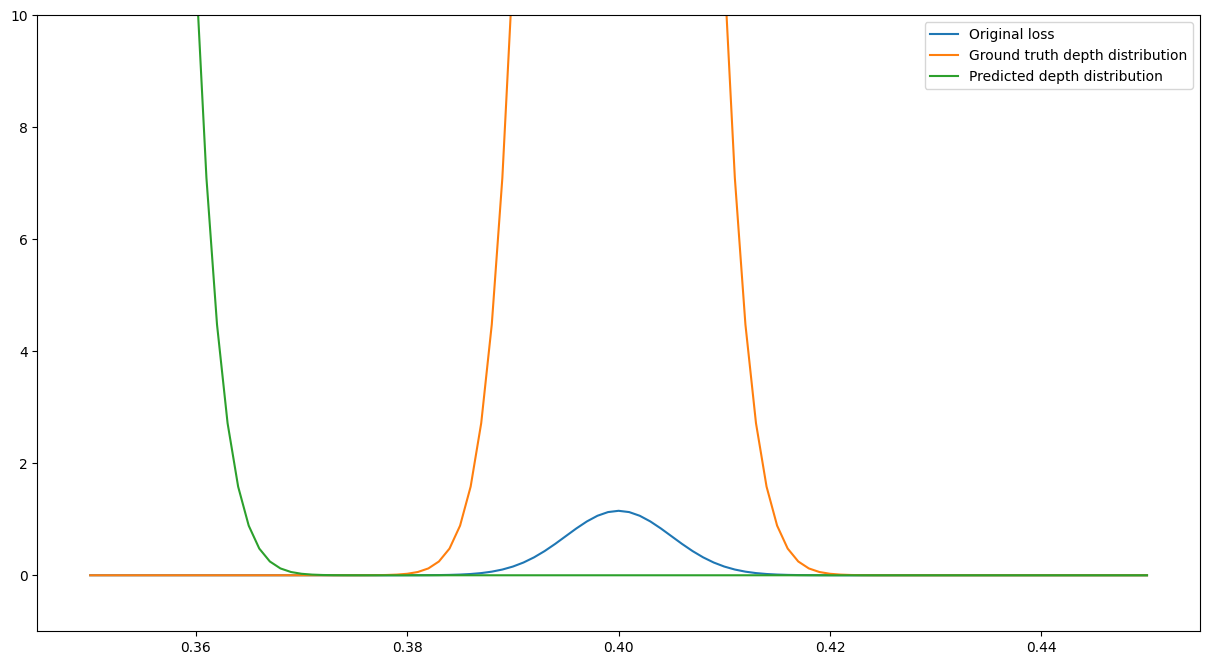

In [17]:
plot_loss(lbound=0.35, rbound=0.45, ylim=[-1, 10], delta=0.001, weight_mean=0.35)

While the new derived loss behaves as it should ()

What we will try now is changing the estimated depth distribution deviation.

Original loss: 0.022783581701730705


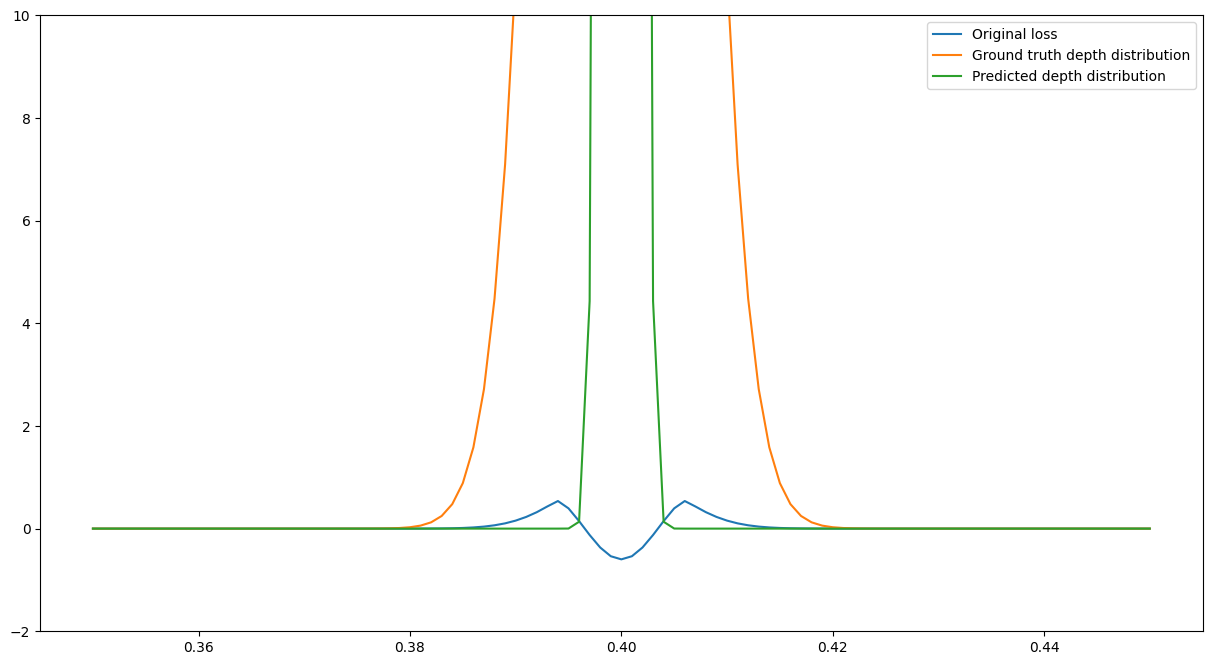

In [10]:
plot_loss(lbound=0.35, rbound=0.45, ylim=[-2, 10], delta=0.001, weight_dev = 0.001)

In [39]:
# MEASURED PARAMETERS: D = 5, ERR = 0.05
plot_loss_interactive(lbound=0, rbound=1, ylim=[-2, 10])

interactive(children=(FloatSlider(value=0.4, description='mean', max=1.0, step=0.01), FloatSlider(value=0.01, …

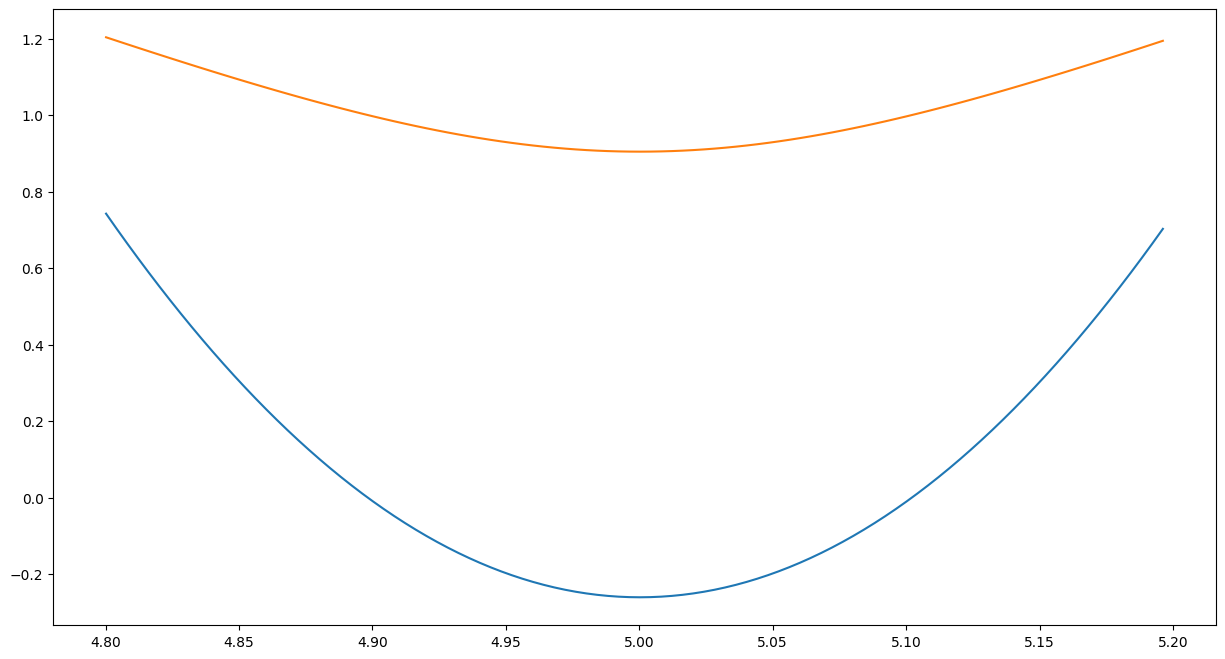

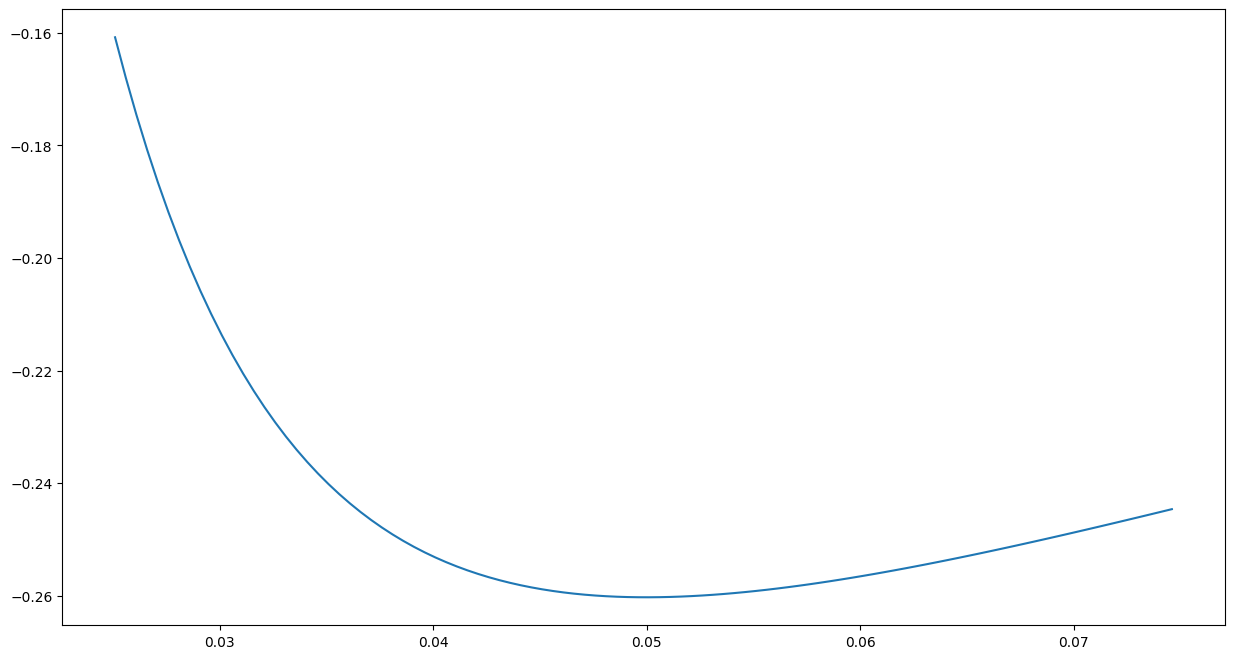

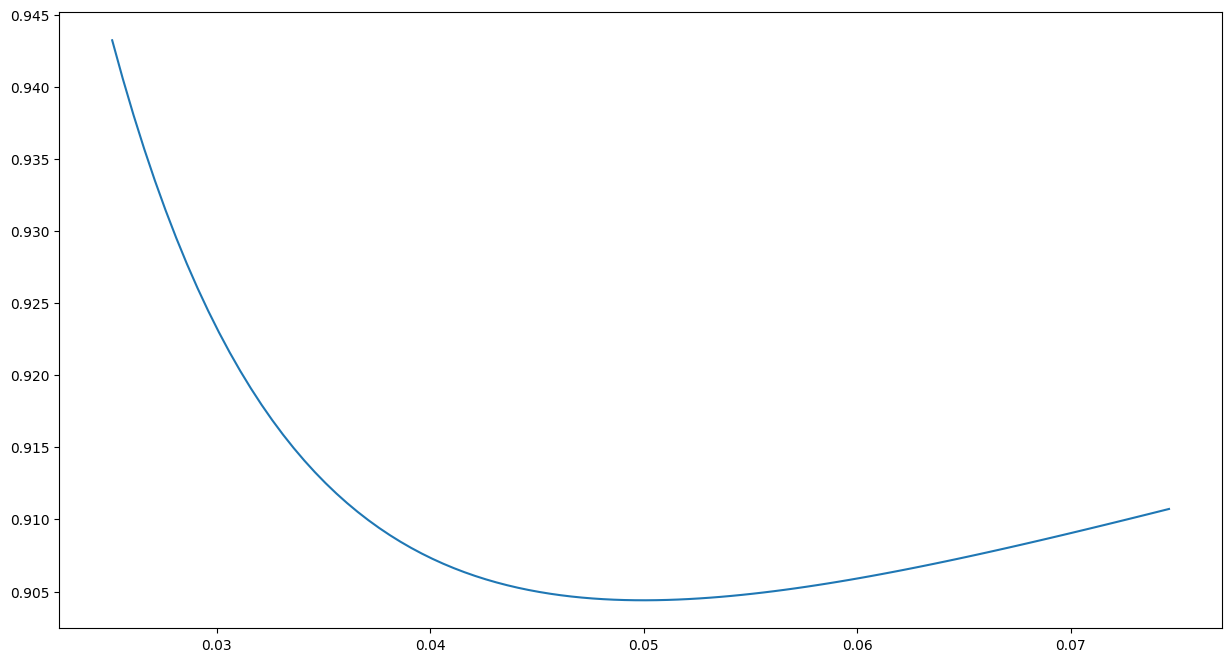

In [85]:
plot_loss_params()